In [1]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: Feb 22, 2018

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import cv2
import glob, os
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from collections import Counter
import pandas as pd
import logging
import yaml
from PIL import Image as pil_image

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import loadcoraldata_utils as coralutils
import keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, Convolution2D, MaxPooling2D
from keras.layers.convolutional import ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.callbacks import Callback
from NeMO_models import FCN
import NeMO_layers
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from NeMO_callbacks import CheckNumericsOps, WeightsSaver

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

%matplotlib notebook

os.chdir("C:/Users/Rechant/Documents/GitHub/NeMO-NET/CNN")

model = load_model('./tmp/FCN_Raster64_TestRun.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D})

c:\users\rechant\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [2]:
# Test export of patches from gdal
imgpath = '../Images/BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI/BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI.tif'
tfwpath = '../Images/BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI/BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI.tfw'
truthpath = '../Images/BIOT-PerosBanhos-sample-habitat-map/BIOT-PerosBanhos-sample-habitat-map.shp'
output_trainpath = '../Images/LO_Training_Patches/'
output_trainrefpath = '../Images/LO_TrainingRef_Patches/'
output_trainfilename = 'rastertrain.txt'
output_validpath = '../Images/LO_Valid_Patches/'
output_validrefpath = '../Images/LO_ValidRef_Patches/'
output_validfilename = 'rastervalid.txt'

PerosBanhos = coralutils.CoralData(imgpath, Truthpath=truthpath, load_type="raster", tfwpath=tfwpath)
PerosBanhos.load_PB_consolidated_classes()

#labelkey = PerosBanhos.class_labels
labelkey = PerosBanhos.consol_labels
num_classes = len(PerosBanhos.PB_consolidated_classes)

with open("init_args - VGG16FCN_Raster64.yml", 'r') as stream:
    try:
        init_args = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

train_loader = ImageSetLoader(**init_args['image_set_loader']['train'])
val_loader = ImageSetLoader(**init_args['image_set_loader']['val'])

if train_loader.color_mode == 'rgb':
    num_channels = 3
elif train_loader.color_mode == '8channel':
    num_channels = 8
y = train_loader.target_size[1]
x = train_loader.target_size[0]

pixel_mean =1023.5*np.ones(num_channels)
pixel_std = 1023.5*np.ones(num_channels)
datagen = NeMOImageGenerator(image_shape = (y,x,num_channels),
    image_resample=True, pixelwise_center=True,
    pixel_mean=pixel_mean, pixelwise_std_normalization=True,
    pixel_std=pixel_std)

train_generator = datagen.flow_from_NeMOdirectory(output_trainpath,
    target_size=(y,x),
    color_mode='8channel',
    classes = labelkey,
    class_mode = 'categorical',
    batch_size = 72,
    shuffle=True)

class_indices_rev = dict((v,k) for k,v in train_generator.class_indices.items()) #flip k,v
print(class_indices_rev)

Found 0 images belonging to 24 classes, split into 10 consolidated classes.
{0: 'Wetlands', 1: 'back reef - pavement', 2: 'back reef - rubble dominated', 3: 'lagoonal sediment apron - sediment dominated', 8: 'lagoonal fringing reefs', 6: 'coralline algal ridge (reef crest)', 7: 'shallow fore reef terrace', 4: 'dense seagrass meadows', 9: 'lagoonal patch reefs', 5: 'Rocky beach'}


{0: 'Other', 1: 'Pavement with algae', 2: 'Rubble with CCA', 3: 'Sediment bare', 4: 'Seagrass', 5: 'Rock', 6: 'Reef crest', 7: 'Low Relief HB', 8: 'High Relief HB', 9: 'Patch reefs'}
(960, 1280)


<IPython.core.display.Javascript object>


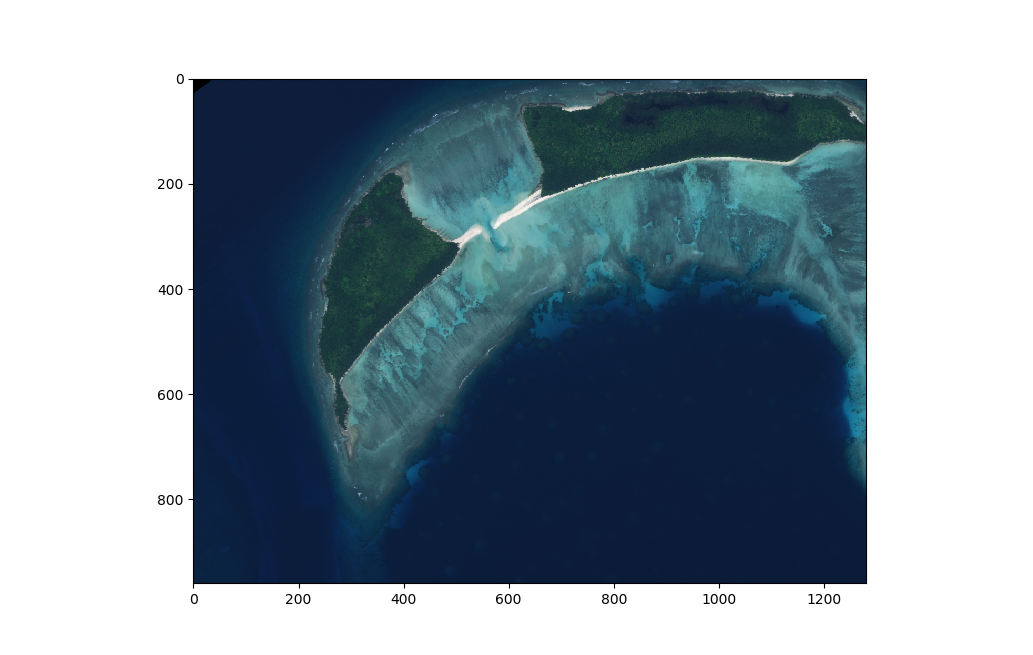

In [3]:
xstart = 400
# xlen = 1200
xlen = 1280
ystart = 400
# ylen = 900
ylen = 960

predict_size = x
PerosBanhos.testimage = PerosBanhos.image[ystart:ystart+ylen,xstart:xstart+xlen,:]
crop_len = int(np.floor(x/2))
offstart = crop_len-int(np.floor(predict_size/2))

Testtruth = PerosBanhos.truthimage[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart]
PerosBanhos.load_PB_consolidated_classes()
class_indices_consol_rev = dict((v,k) for k,v in PerosBanhos.PB_consolidated_classes.items()) #flip k,v
print(class_indices_consol_rev)

max_R = np.max(PerosBanhos.testimage[:,:,4])
max_G = np.max(PerosBanhos.testimage[:,:,2])
max_B = np.max(PerosBanhos.testimage[:,:,1])
Perostest_RGB = np.rollaxis(np.asarray([1/max_R*PerosBanhos.testimage[:,:,4], 1/max_G*PerosBanhos.testimage[:,:,2], 1/max_B*PerosBanhos.testimage[:,:,1]]),0,3)
print(Testtruth.shape)

plt.figure(1)
plt.imshow(Perostest_RGB)
plt.show()

In [8]:
PerosBanhos.set_depth(2047)
print("Total Lines: ", Testtruth.shape[0])
whole_predict, num_predict, truth_predict, accuracy = PerosBanhos.predict_on_whole_image(model, image_size = x, spacing = (32,32), predict_size = predict_size, num_lines=None, lastchannelremove=False, reshapeflag=True)
# for i in range(whole_predict.shape[0]):
#     for j in range(whole_predict.shape[1]):
#         whole_predict[i,j] = train_generator.class_indices[class_indices_rev[whole_predict[i,j]]]

print(whole_predict.shape)
Testtruth_consolidated = PerosBanhos.truthimage_consolidated[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart]
accuracy = 100*np.asarray((whole_predict == Testtruth_consolidated)).astype(np.float32).sum()/(whole_predict.shape[0]*whole_predict.shape[1])
print(accuracy)

Total Lines:  960
(960, 1280)ol: 1216/ 1217 completed
62.243733723958336


<IPython.core.display.Javascript object>


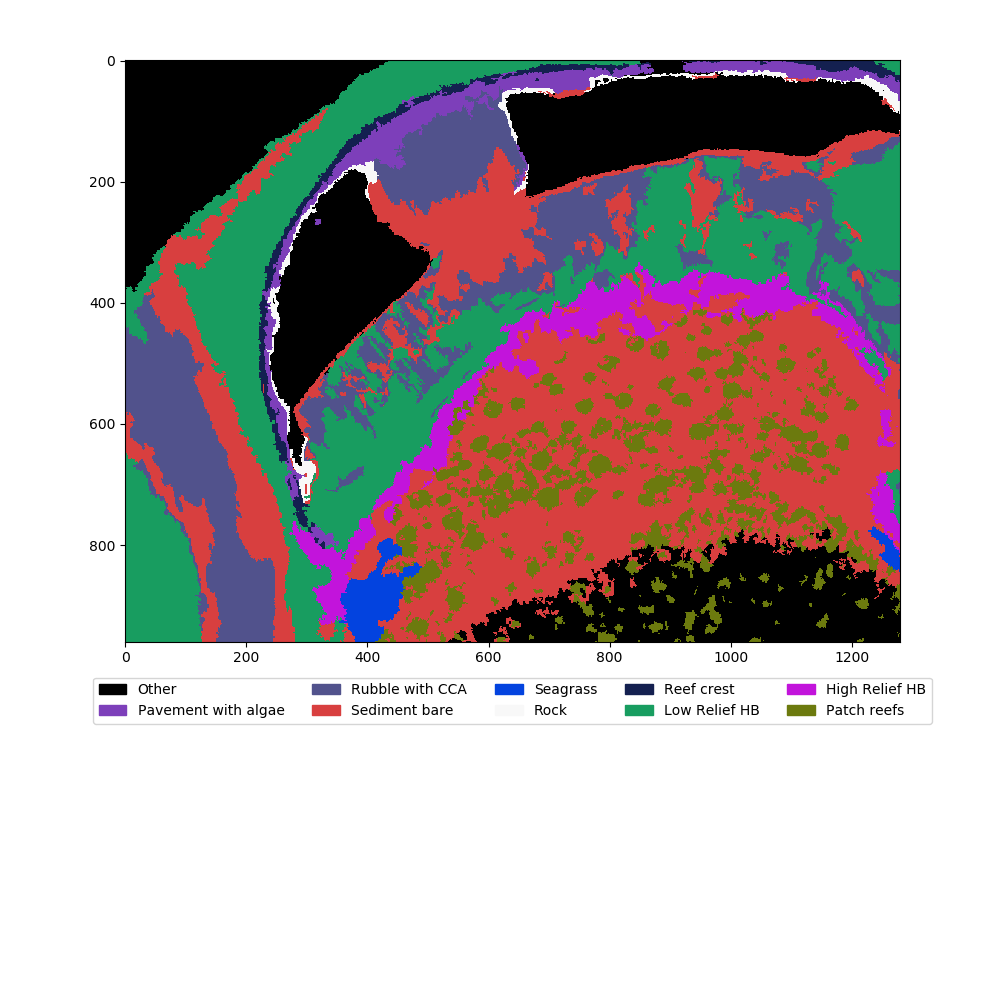

<IPython.core.display.Javascript object>


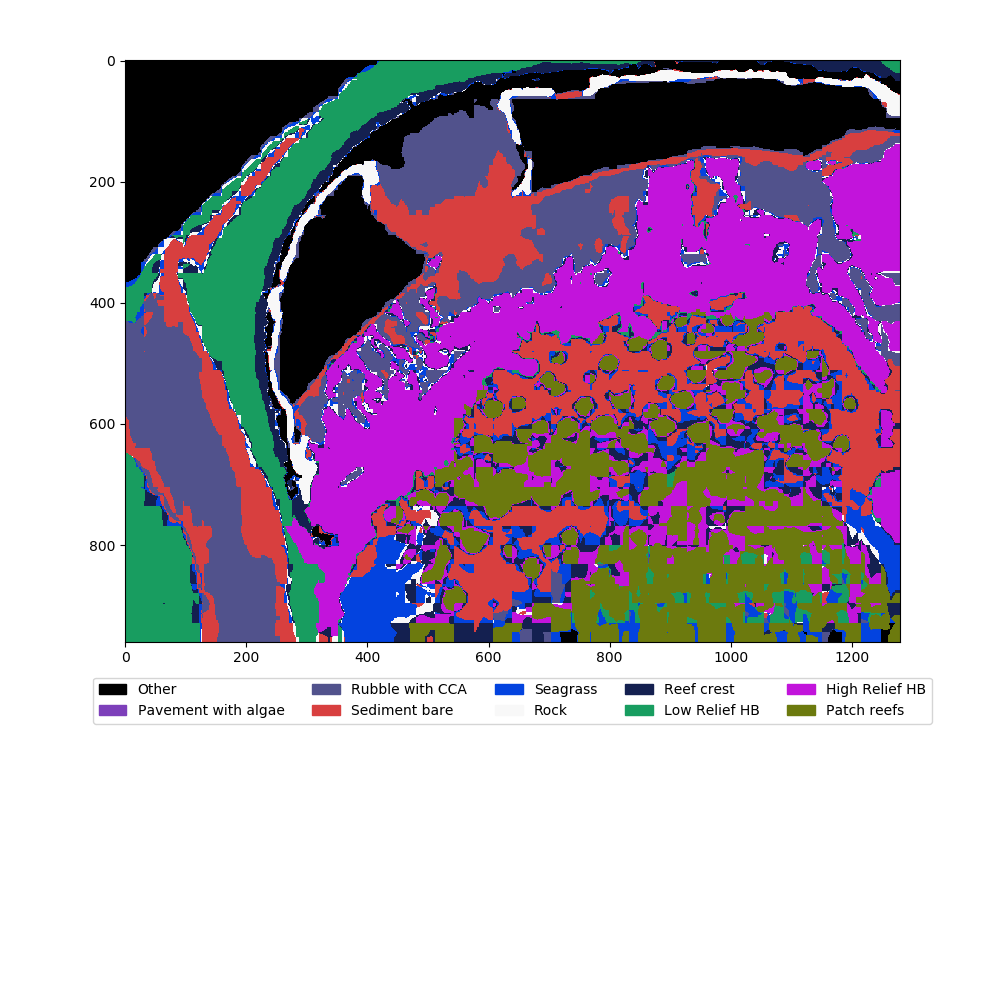

In [9]:
cmap_consol = colors.ListedColormap(['xkcd:black', '#7d3fba', '#51528c', '#d83f3f', 'xkcd:blue',
                             '#f8f8f8', '#142050', '#189d60', '#c214db', 'xkcd:murky green'])
bounds = [i-0.5 for i in range(len(class_indices_consol_rev)+1)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap_consol.N)

fig = plt.figure(2,figsize=(10,10))
ax = plt.subplot(111)
ax.imshow(Testtruth_consolidated, interpolation='nearest', cmap=cmap_consol, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_consol(i)) for i in range(len(class_indices_consol_rev))],
           ['{}'.format(class_indices_consol_rev[i]) for i in range(len(class_indices_consol_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=5)
# ax.set_axis_off()
plt.show()

fig = plt.figure(3,figsize=(10,10))
ax = plt.subplot(111)
ax.imshow(whole_predict, interpolation='nearest', cmap=cmap_consol, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height])
ax.legend([mpatches.Patch(color=cmap_consol(i)) for i in range(len(class_indices_consol_rev))],
           ['{}'.format(class_indices_consol_rev[i]) for i in range(len(class_indices_consol_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=5)
#ax.set_axis_off()
plt.show()

In [18]:
print(whole_predict[780:800,720:740])
print(num_predict[780:800,720:740])
print(whole_predict_dnum[780:800,720:740])
print(np.round(whole_predict_dnum[780:800,720:740]))

[[ 113.  113.  113.  113.  113.  113.  113.  113.  113.  112.  112.  112.
   103.  103.  103.  103.  103.  103.   82.   82.]
 [ 113.  113.  113.  113.  113.  113.  113.  113.  113.  112.  112.  112.
   103.  103.  103.  103.  103.  103.   94.   88.]
 [ 113.  113.  113.  113.  113.  113.  113.  113.  113.  112.  112.  112.
   112.  103.  103.  103.  103.  103.  103.   94.]
 [ 113.  113.  113.  113.  113.  113.  113.  113.  113.  112.  112.  112.
   112.  103.  103.  103.  103.  103.  103.   94.]
 [ 108.  108.  117.  117.  117.  117.  117.  117.  117.  117.  117.  117.
   117.  108.  108.  108.  111.  111.  111.  102.]
 [ 108.  108.  108.  117.  117.  117.  117.  117.  117.  117.  117.  117.
   108.  108.  108.  108.  111.  111.  102.  102.]
 [ 108.  108.  108.  117.  117.  117.  117.  117.  117.  117.  117.  108.
   108.  108.  108.  108.  111.  102.  102.  102.]
 [ 108.  108.  108.  108.  117.  117.  117.  117.  117.  108.  108.  108.
   108.  108.  108.  108.  102.  102.  102.  102.]
